In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-30 09:07:34,653 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/LOO/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/LOO/A-crossval-swarm_12-005_2018-01-28_07-01-05.pickle',
       '../../results/LOO/A-crossval-swarm_51-009_2018-01-28_08-17-06.pickle',
       '../../results/LOO/A-crossval-swarm_52-001_2018-01-28_08-18-19.pickle',
       '../../results/LOO/B-crossval-swarm_12-005_2018-01-28_08-49-46.pickle',
       '../../results/LOO/B-crossval-swarm_51-009_2018-01-28_19-37-02.pickle',
       '../../results/LOO/B-crossval-swarm_52-001_2018-01-28_19-37-46.pickle'], 
      dtype='<U68')

In [3]:
subjects = ['12-005', '51-009', '52-001']
models = ['A', 'B', 'C', 'D']
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
def calc_srd(ytyp, assert_params):
    y_true, y_pred = ytyp
    return [p2pspatial.imgproc.srd_loss((yt, yp), w_scale=assert_params['w_scale'],
                                        w_rot=assert_params['w_rot'],
                                        w_dice=assert_params['w_dice'])
            for yt, yp in zip(y_true.iterrows(), y_pred.iterrows())]

In [5]:
loss = {a: {s: None for s in subjects} for a in models}
for file in pickle_files:
    y_test, y_pred, best_params, specifics = pickle.load(open(file, 'rb'))
    for key, value in six.iteritems(assert_params):
        assert np.isclose(specifics[key], value)
    n_folds = specifics['n_folds']
    assert len(y_pred) == n_folds
    assert len(y_test) == n_folds
    assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    thisloss = p2pu.parfor(calc_srd, zip(y_test, y_pred), func_args=[assert_params])
    loss[model][subject] = [item for sublist in thisloss for item in sublist]

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009
Processing Model A, Subject 52-001
Processing Model B, Subject 12-005
Processing Model B, Subject 51-009
Processing Model B, Subject 52-001


In [11]:
loss['C']['12-005'] = [15.35681899964193, 16.055962837539056, 15.517801946050835, 14.636250021956094, 
                       15.802833113507182, 15.64185609854228, 14.486890541447801, 15.524159076674799,
                       15.670631424967771, 14.675370108261678, 15.68244402478642, 15.945557709065838]

In [13]:
loss['C']['51-009'] = [26.578497595712467, 25.103853374519463, 25.21933855525642, 29.174684702667737,
                     26.10930776325391, 26.575584122915252, 26.10930776325391]

In [15]:
loss['C']['52-001'] = [24.645198244343256, 25.35169846854032, 24.3718819422963, 23.866990023536182,
                       24.830326801919927, 25.818253470032563, 25.896198969920693, 25.7501404963739,
                       25.4245121172169, 22.742877281465233, 25.430441401680103, 26.107972534077415,
                       24.5535118845059]

In [17]:
loss['D']['12-005'] = [17.421355412255792, 16.99321339173263, 15.798142525894495, 16.2996782005596,
                       15.22831421592841, 14.500390666277616, 15.808192307173545, 16.019660401069007,
                       16.45223802183233, 15.811642020756578, 15.739707430957676, 16.36740384240158,
                       16.681806166832562, 15.894466642923213, 16.484912618091524]

In [19]:
loss['D']['51-009'] = [28.909998497543672, 27.419163976973408]

In [21]:
loss['D']['52-001'] = [24.128929140182233, 25.220381861815845, 24.42728336909742, 23.682808983762282,
                       24.34858658277853, 24.979762280495404, 25.026329735306774, 25.40486842259406,
                       24.465156591329954, 23.15664911886859]

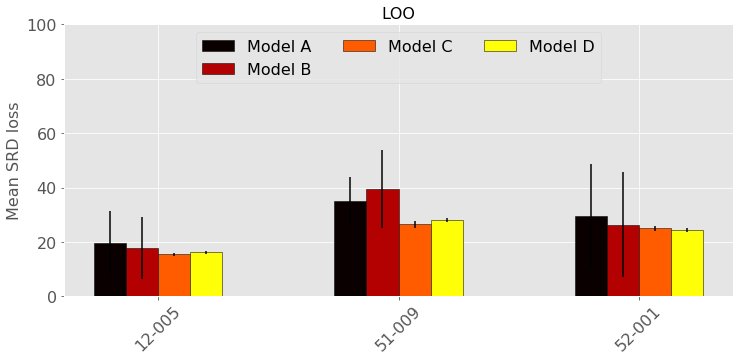

In [22]:
N = len(subjects)
width = 0.4 / N
ind = np.arange(N)

fig, ax = plt.subplots(figsize=(12, 5))
cm = plt.get_cmap('hot')

rects = {}
for m, model in enumerate(models):
    for s, subject in enumerate(subjects):
        if not loss[model][subject]:
            continue
        r = ax.bar(s + m * width, np.mean(loss[model][subject]), 
                   width, yerr=np.std(loss[model][subject]), 
                   color=cm(m / len(models)), edgecolor='k', 
                   label='Model %s' % model)
        rects[model] = r[0]
ax.set_xticks(ind + (len(rects) - 1) / 2 * width)
ax.set_xticklabels(subjects, rotation=45, ha='center', fontsize=16)
ax.legend([rects[m] for m in models if m in rects],
          ['Model ' + m for m in models if m in rects], 
          ncol=3, loc='upper center', fontsize=16)
allvals = [[item for sublist in filter(None, loss[m].values())
            for item in sublist]
           for m in models]
maxheight = max([item for sublist in allvals for item in sublist])
ax.set_ylim(0, np.ceil(maxheight / 20) * 20)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylabel('Mean SRD loss', fontsize=16)
ax.set_title(os.path.basename(os.path.dirname(results_dir)), fontsize=16)
fig.savefig(os.path.join(results_dir, 'srd_loss.png'))